In [2]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2

c:\Users\chans\Documents\Sopheak\Rupp\IOT\trash-classification\env\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [20]:
class_names = ['Can', 'Plastic']

# Load the model

In [22]:
model = keras.models.load_model('models/ai-model.keras')

# prediction function
def predict_image(model, img_path, class_names):    
    img = cv2.imread(img_path)
    if img is None:
        print("Error: Image not found.")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    
    # Convert to array - keep in [0, 255] range! Model has preprocessing built-in
    img_array = img_resized.astype("float32")  # NO /255 division!
    img_array = np.expand_dims(img_array, axis=0)  # (1, 224, 224, 3)
    
    p = float(model.predict(img_array, verbose=0)[0][0])
    
    # interpret p = P(class 1 | x)
    if p >= 0.5:
        pred_cls = class_names[1]
        conf = p * 100
    else:
        pred_cls = class_names[0]
        conf = (1 - p) * 100   # confidence for class 0

    print(f"Predicted: {pred_cls} ({conf:.2f}%)  | p(class_1)={p:.3f}")

    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"{pred_cls} ({conf:.1f}%)")
    plt.show()
    
    return pred_cls, conf

# Prediction

Predicted: Can (100.00%)  | p(class_1)=0.000


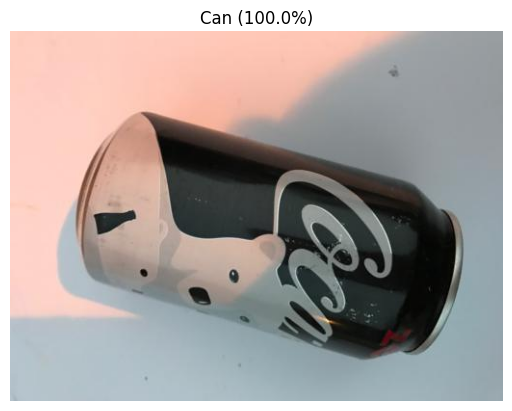

Predicted: Can (100.00%)  | p(class_1)=0.000


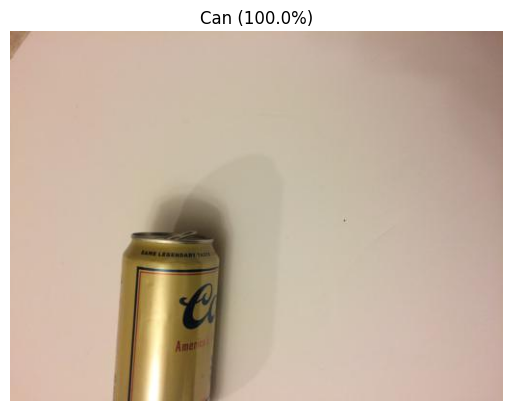

Predicted: Can (99.45%)  | p(class_1)=0.006


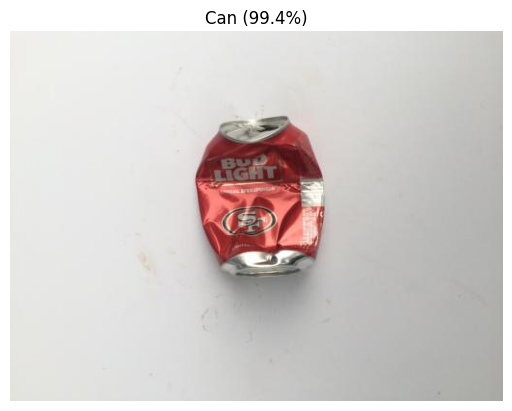

Predicted: Plastic (99.99%)  | p(class_1)=1.000


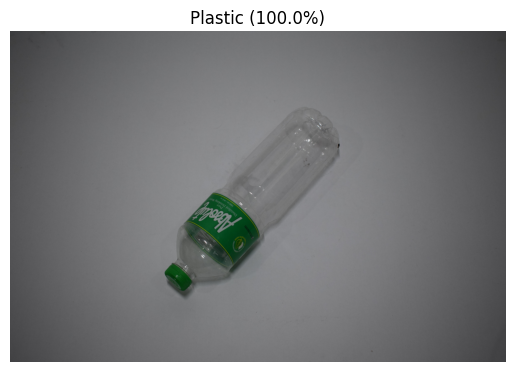

Predicted: Plastic (99.64%)  | p(class_1)=0.996


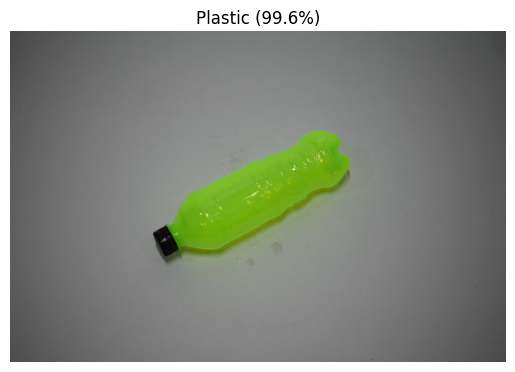

Predicted: Plastic (97.32%)  | p(class_1)=0.973


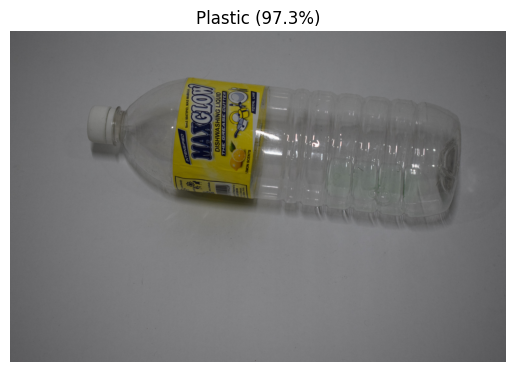

('Plastic', 97.31787443161011)

In [25]:
predict_image(model, 'AluCan61.jpg', class_names)
predict_image(model, 'AluCan59.jpg', class_names)
predict_image(model, 'AluCan62.jpg', class_names)
predict_image(model, 'Plastic3.jpg', class_names)
predict_image(model, 'Plastic2.jpg', class_names)
predict_image(model, 'Plastic1.jpg', class_names)

# Model for train on Rasberry Pi, need to use tflite for lightweight model

In [27]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="models/ai-model-fp32.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape:", input_details[0]['shape'])
print("Output shape:", output_details[0]['shape'])

Input shape: [  1 224 224   3]
Output shape: [1 1]


c:\Users\chans\Documents\Sopheak\Rupp\IOT\trash-classification\env\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [28]:
# TFLite prediction function for Raspberry Pi
def predict_image_tflite(interpreter, img_path, class_names):
    img = cv2.imread(img_path)
    if img is None:
        print("Error: Image not found.")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    
    # Convert to array - keep in [0, 255] range! Model has preprocessing built-in
    img_array = img_resized.astype("float32")  # NO /255 division!
    img_array = np.expand_dims(img_array, axis=0)  # (1, 224, 224, 3)
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], img_array)
    
    # Run inference
    interpreter.invoke()
    
    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
    p = float(output_data[0][0])
    
    # Interpret p = P(class 1 | x)
    if p >= 0.5:
        pred_cls = class_names[1]
        conf = p * 100
    else:
        pred_cls = class_names[0]
        conf = (1 - p) * 100
    
    print(f"[TFLite] Predicted: {pred_cls} ({conf:.2f}%)  | p(class_1)={p:.3f}")
    
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"TFLite: {pred_cls} ({conf:.1f}%)")
    plt.show()
    
    return pred_cls, conf

# Test TFLite Model (Raspberry Pi version)

[TFLite] Predicted: Can (100.00%)  | p(class_1)=0.000


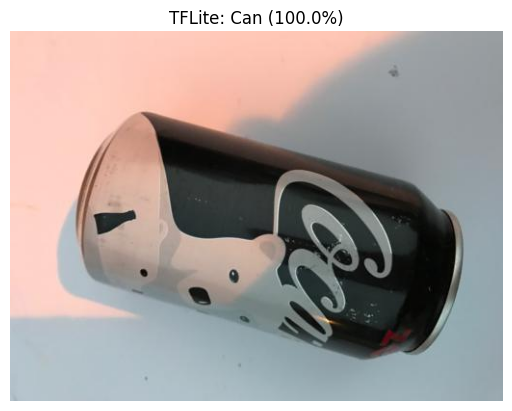

[TFLite] Predicted: Plastic (97.32%)  | p(class_1)=0.973


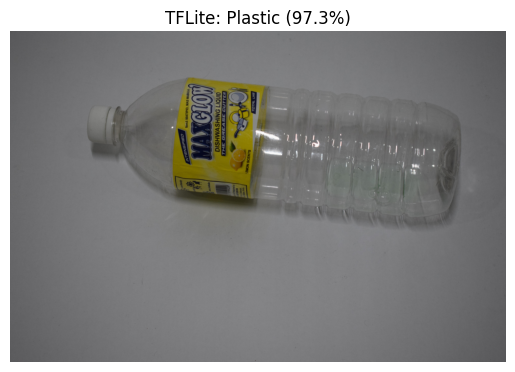

('Plastic', 97.3177969455719)

In [29]:
# Test TFLite predictions - should give same results as Keras model
predict_image_tflite(interpreter, 'AluCan61.jpg', class_names)
predict_image_tflite(interpreter, 'Plastic1.jpg', class_names)